In [1]:
# NOTES FROM MEETING
# No cell should take more than 20 minutes to run
# Please limit to one temporary collection (must be deleted at end of notebook). No external files
# Try to reduce single-line cells

# Mini-competition -
# Challenge: Limit to 75 lines of code (100 for team 1)! (excluding imports)
# Fit Success Rate: Fitting method with highest fit success rate
# Fit Average error: Fitting method with lowest fit error rate
# Fit Time complexity: Fitting method with lowest time expended
# Notebook housekeeping: Cleanest-looking notebook win!

# Sigmoid Criteria Curve Fitting: CDF Approach
**Contributors:** 

**Achievement:**

**Requirements:**


## Example of cell markdown
**This is a note:** Please have markdown before each cell. In this format!

In [140]:
# Import packages you need
import sys
sys.path.append('../..')
from pymongo import UpdateOne
from pymongo import MongoClient
from tqdm import tqdm
from exploration.config import mongo_inst
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm 
import scipy
import seaborn as sns
from scipy.optimize import curve_fit
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import t
# from mlpp.data_modeling.sigmoid_fitting import fit_normal_cdf

In [3]:
# Instantiate your mongo instance, classes, and any config/global vars
client = MongoClient(port=27017)
db = client.osu_random_db
bm_ids = list(map(lambda c: c['_id'], db['beatmap_criteria_curve'].find({}, {})))

In [4]:
bm_data = {}
for i in bm_ids:
    bm_data[i] = list(db['beatmap_criteria_curve'].find({"_id": i}, {"_id": 0, "no_mod.total": 1, "no_mod.n_pass": 1}))

In [5]:
# find a good user
first_bm_total = bm_data[104229][0]["no_mod"]["total"]
first_bm_n_pass = bm_data[104229][0]["no_mod"]["n_pass"]

In [6]:
ind_good = []
k = 0
for total in first_bm_total: 
    if (total != 0):
        ind_good.append(k)
    k = k + 1

In [7]:
first_bm_good_total = [first_bm_total[i] for i in ind_good]
first_bm_good_npass = [first_bm_n_pass[i] for i in ind_good]

In [8]:
x = range(len(first_bm_good_total))
y = np.asarray(first_bm_good_npass) / np.asarray(first_bm_good_total)

In [117]:
def helper_take_out_zero(bm_total):
    good_index = []
    k = 0
    for total in bm_total: 
        if (total != 0):
            good_index.append(k)
        k = k + 1
    bm_good_total = [bm_total[i] for i in good_index]
    return bm_good_total
len(helper_take_out_zero(first_bm_total))

93

In [13]:
n = len(first_bm_good_total)
x = range(0, n) 
f = lambda x, mu, sigma: scipy.stats.norm(mu,sigma).cdf(x)

mu, sigma = scipy.optimize.curve_fit(f, x, y)[0]

# plt.scatter(x, y)

total = 0
for i in x:
    error = (y[i] - scipy.stats.norm(mu,sigma).cdf(i))**2
    total += error
print(total / n)
    

# scipy.stats.norm(mu,sigma).cdf(x)
# scipy.optimize.curve_fit(f,x,y)

0.004459652369558242


In [23]:
# take in one bm_id and gets y
def find_nPassOverTotal_for_one_beatmap (bm):
    bm_total_nPass = list (zip (bm_data[bm][0]["no_mod"]["total"], bm_data[bm][0]["no_mod"]["n_pass"]))
    bm_total_nPass_noZero = [total_nPass for total_nPass in bm_total_nPass if total_nPass[0] != 0]
    y = np.asarray(list(zip(*bm_total_nPass_noZero))[1]) / np.asarray(list(zip(*bm_total_nPass_noZero))[0])
    return y

In [19]:
bm_ys = {}

for i in bm_ids:
    bm_ys[i] = find_nPassOverTotal_for_one_beatmap (i)

In [56]:
def fit_normal_cdf(y):

    """Fits a set of cartesian points to the normal cdf

    Parameters
    ----------
    x (int []):  Array of point x-coordinates
    n_users (int): Array of point y-coordinates

    Returns
    -------
    params (tuple): Tuple of parameters for the normal cdf
    error (float): Least squares error from points given
    """
    
#     def helper_take_out_zero(bm_total):
#         good_index = []
#         k = 0
#         for total in bm_total: 
#             if (total != 0):
#                 good_index.append(k)
#             k = k + 1
#         bm_good_total = [bm_total[i] for i in good_index]
#         return bm_good_total

    x = range(0, len(y))
    try:
        f = lambda x, mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)
        mu,sigma = scipy.optimize.curve_fit(f, x, y)[0]
    
    except RuntimeError:
        print("error")
        return "Error - curve_fit failed"
    
    total = 0
    for i in x:
        error = (y[i] - scipy.stats.norm(mu,sigma).cdf(i))**2
        total += error
    
    mse = total / n
    
    return scipy.stats.norm(mu,sigma).cdf(x), mse

    pass

In [57]:
fitted_curves_with_errors = {}

for i in bm_ys.keys():
    fitted_curves_with_errors[i] = fit_normal_cdf(bm_ys[i])

error


In [59]:
[id for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse, str)]

[1605148]

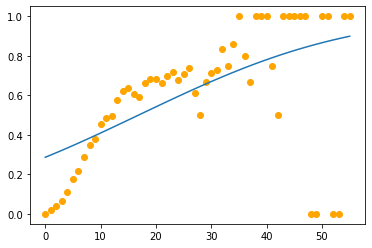

In [93]:
# visualization
plt.plot(fit_normal_cdf(find_nPassOverTotal_for_one_beatmap(1762729))[0])
plt.scatter(range(len(find_nPassOverTotal_for_one_beatmap(1762729))),find_nPassOverTotal_for_one_beatmap(1762729), color = "orange")

In [74]:
# max([fitAndMse[1] for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse[1], float)])

0.18621213279190263

In [82]:
success_rate = len([fitAndMse[1] for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse[1], float)])/len(fitted_curves_with_errors)
avg_mse = np.mean([fitAndMse[1] for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse[1], float)])
avg_mse

0.013217890460951974

In [138]:
x = np.arange(len(find_nPassOverTotal_for_one_beatmap(1762729))).reshape(-1, 1)
# x = range(len(find_nPassOverTotal_for_one_beatmap(1762729)))
y = find_nPassOverTotal_for_one_beatmap(1762729).astype("int")
model = LogisticRegression().fit(x, y)

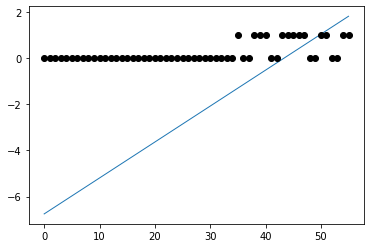

In [139]:
# model.predict_proba(x)

# and plot the result
plt.scatter(x, y, color='black', zorder=20)
# X_test = np.linspace(-5, 10, 300)

plt.plot(x, model.coef_ * x + model.intercept_, linewidth=1)
# plt.axhline(.5, color='.5')

# plt.ylabel('y')
# plt.xlabel('X')
# plt.xticks(range(-5, 10))
# plt.yticks([0, 0.5, 1])
# plt.ylim(-.25, 1.25)
# plt.xlim(-4, 10)
# plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
#            loc="lower right", fontsize='small')
# plt.tight_layout()
# plt.show()

In [ ]:
def fit_t_cdf(y):

    """Fits a set of cartesian points to the normal cdf

    Parameters
    ----------
    x (int []):  Array of point x-coordinates
    n_users (int): Array of point y-coordinates

    Returns
    -------
    params (tuple): Tuple of parameters for the normal cdf
    error (float): Least squares error from points given
    """

    x = range(0, len(y))
    try:
        df = len(y) - 1
        f = lambda x, mu,sigma: scipy.stats.t(df).cdf(x)
        scipy.optimize.curve_fit(f, x, y)[0]
    
    except RuntimeError:
        print("error")
        return "Error - curve_fit failed"
    
    total = 0
    for i in x:
        error = (y[i] - scipy.stats.t(df).cdf(i))**2
        total += error
    
    mse = total / n
    
    return scipy.stats.norm(mu,sigma).cdf(x), mse

    pass

In [145]:
df = len(y) - 1

x = range(len(find_nPassOverTotal_for_one_beatmap(1762729)))
y = find_nPassOverTotal_for_one_beatmap(1762729)

f = lambda x: scipy.stats.t.cdf(df)
scipy.optimize.curve_fit(f, x, y)


ValueError: Unable to determine number of fit parameters.

In [20]:
# Load the curve data

In [21]:
# Run all CDF curve fits & store in beatmap_criteria_curve collection

In [22]:
# Load the beatmap attribs data

In [ ]:
# Visualisations of correlation between CDF mean/std with attribs

In [ ]:
# fit success-rate summary table with (3 rows 1 for each CDF fit) (4 columns 1* - 4*, 4* - 6*, 6* plus, all)

In [ ]:
# for curves that could be fit, error summary table with same layout as above

## Conclusion
Don't forget to provide a conclusion